# Homotopic optimal control of inverted pendulum

## Dynamics

In [ ]:
from sympy import *
init_printing()

In [ ]:
# state variables
x, v, theta, omega = symbols("x v \\theta, \\omega", real=True)
s = Matrix([x, v, theta, omega])
s.T

In [ ]:
# control parameter
u = symbols('u', real=True)

# state equations of motion
ds = Matrix([v, u, omega, sin(theta) - u*cos(theta)])
ds

In [ ]:
# homotopy parameters
alpha, beta = symbols('\\alpha \\beta', real=True, nonegative=True)

# homotopy between effort and time
L = alpha + (1-alpha)*abs(u)

# homotopy between energy and effort/time
L = beta*L + (1-beta)*u**2
L.simplify()

L = alpha + (1-alpha)*u**2
print(latex(L))

In [ ]:
# costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True, nonzero=True)
l.T

In [ ]:
# Hamiltonian
H = l.dot(ds) + L
H

In [ ]:
# costate equations of motion
dl = -H.diff(s)
dl

In [ ]:
# optimal control; note that alpha dissappears
# because effort and time optimality are equivalent in this case
us = solve(H.diff(u), u)[0]
us.simplify()
us

In [ ]:
print(latex(us.subs(alpha, 1).args[1]))

In [ ]:
solve(uss.subs(alpha, 0).args[1])

## Base trajectory
We first solve for a base trajectory, which will subsequently be used to iniate the forthcoming homotopy sequence approach to reaching the difficultly found bang-bang optimal control.

In [1]:
import sys, numpy as np, matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sys.path.append('../src/')
from pendulum import Pendulum
%matplotlib inline
from scipy.integrate import simps

In [110]:
# instantiate problem
seg = Pendulum(1)

# solve arguments
s0 = [0,0,np.pi,0]
alpha = 0
Tlb = 4
Tub = 10
lb = 100
seg.bound = True

In [ ]:
# solve
zg = None
#zg = [10.21795266,  0.19885557,  0.77306339,  0.99997456,  0.83067696]
#zg = [6.96209275,  0.33095384,  0.29435989, -1.11307474, -2.53239123]
#zg = [7, 0, 0, 0, 0]
#zg = [ 6.91966748,  0.27344678, -0.01878282, -1.28774874, -2.15982032]
zg = [ 4.93510843, -1.86727568, -9.93748336, -9.55431702,  4.617935  ]
#zg = [ 6.40484939,  0.19315055, -0.85643521, -2.52869206, -1.87188246]
while True:
    #zg = np.hstack(([6], np.random.random(4)))
    z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb, z=zg)
    if feas:
        break
    else:
        print('Retry')

In [ ]:
# simulate the solution's resultant trajectory
tl, sl, ul = seg.propagate(z[0], s0, z[1:], alpha, atol=1e-12, rtol=1e-12, u=True)

In [ ]:
# plot states and control
fig, ax = seg.plot_states(tl, sl, ul)

In [ ]:
# plot geometric trajectory
fig, ax = seg.plot_traj(tl, sl)

In [ ]:
seg.ub = max(abs(ul))
#seg.ub = 3
seg.bound = True
#Tub = tl[-1]
lb = abs(sl[0, seg.sdim:])
#lb = 1000
z

## Policy homotopy

```python
zo = None
a = 0
while a < 1:
    z = solve(zo, a)
    if succesfull(z):
        zo = z
        a = increase(a)
    else:
        a = decrease(a)
```

## Forward homotopy $\alpha: 0 \rightarrow 1$
This brings us to a bang-bang policy with an appropriate magnitude, which is realisable from the original quadratic policy.

In [111]:
#sols = seg.homotopy(s0, alpha, Tlb, Tub, lb, z, 1, step=0.05)
sols = np.load("ph.npy")

In [ ]:
sols2 = seg.homotopy(s0, sols[-1][1], Tlb, Tub, 10, sols[-1][0], 1, step=0.01)

In [ ]:
sols[-1]

In [ ]:
#np.save('ph.npy', np.flip(sols, axis=0))

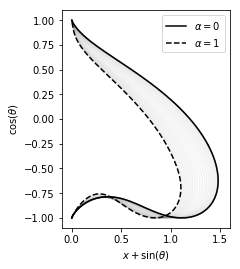

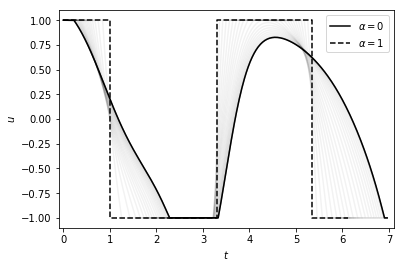

In [113]:
# plot the forward homotopy 
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
for i in range(len(sols)):
    z = sols[i][0]
    a = sols[i][1]
    tl, sl, ul = seg.propagate(z[0], s0, z[1:], a, u=True)
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    if a == 0:
        ax.plot(x, y, "k-", alpha=1, label=r"$\alpha=0$")
        ax1.plot(tl, ul, "k-", alpha=1, label=r"$\alpha=0$")
    elif a >= 0.999:
        ax.plot(x, y, "k--", alpha=1, label=r"$\alpha=1$")
        ax1.plot(tl, ul, "k--", alpha=1, label=r"$\alpha=1$")
    else:
        ax.plot(x, y, "k-", alpha=0.05)
        ax1.plot(tl, ul, "k-", alpha=0.05)
ax.set_aspect('equal')
ax.legend()
ax1.set_xlim(-0.1, 7.1)
ax1.set_ylim(-1.1, 1.1)
ax.set_xlim(-0.1, 1.6)
ax.set_ylim(-1.1, 1.1)
ax1.legend()
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$u$')
plt.show()
fig.savefig("phs.pdf", bbox_inches='tight')
fig1.savefig("phu.pdf", bbox_inches='tight')

In [ ]:
sols

## Random walks

```python
T = []
so = snom
zo = znom
while len(T) < N:
    s = perturb(so, ds)
    z = solve(s, zo)
    if succesfull(z):
        so = s
        zo = z
        T.append((so, zo))
        ds = increase(ds)
    else:
        ds = decrease(ds)
        
```

In [ ]:
# arguments
so = s0
#zo = sols[0][0]
alpha = 0
n = 5
Tlb = 0
Tub = 15
lb = 5
nw = 10

# random walks
#T = seg.random_walk_par(so, zo, alpha, n, Tlb, Tub, lb, nw, dsm=0.02, verbose=True)
T = np.load('../src/pendulum_rw.npy')

In [ ]:
#np.save('pqdb.npy', T)

In [ ]:
# plot the random walks
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)

# for each random walk
first = False
for t in T:
    
    # initial state
    s0 = t[0]
    
    # decision vector
    z = t[1]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if first:
        ax.plot(x, y, "k-", alpha=1, label="Nominal")
        ax1.plot(tl, ul, "k-", alpha=1, label="Nominal")
        first = False
    else:
        ax.plot(x, y, "k-", alpha=0.1)
        ax1.plot(tl, ul, "k-", alpha=0.1)
ax.set_aspect('equal')
#ax.legend()
#ax1.legend()
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()
#fig.savefig('pqdbs.pdf', bbox_inches='tight')
#fig1.savefig('pqdbu.pdf', bbox_inches='tight')

## Database homotopy

In [114]:
#res = seg.homotopy_db(T, 0, 0, 15, 5, 1, step=0.01)
res = np.load('pqhdb.npy')
res[0]

array([list([0, 0, 3.141592653589793, 0]),
       array([ 6.96209275,  0.33095384,  0.29435989, -1.11307474, -2.53239123]),
       0], dtype=object)

In [116]:
res.shape

(945, 3)

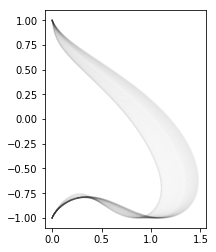

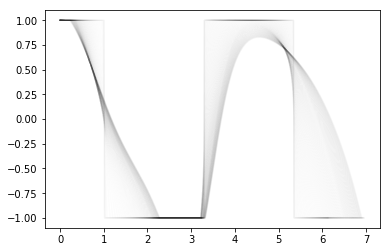

In [115]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
seg.bound = True
seg.ub = 1

for r in res[:105]:
    
    # initial state
    s0 = r[0]
    
    # decision vector
    z = r[1]
    
    # homotopy parameter
    alpha = r[2]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if alpha > 1.2:
        ax.plot(x, y, "k--", alpha=1)
        ax1.plot(tl, ul, "k--", alpha=1)
    else:
        ax.plot(x, y, "k-", alpha=0.01)
        ax1.plot(tl, ul, "k-", alpha=0.01)
ax.set_aspect('equal')
    
plt.show()    
fig1.savefig('phdbu.pdf')

In [ ]:
res[:105]

## Training a neural network

In [94]:
from ann import *
import cloudpickle as cp
from matplotlib.ticker import FormatStrFormatter

In [ ]:
np.save("")

In [117]:
# generate the databases
#data = seg.gen_db(res[:105], cat=True)
data = np.load('pqhanndb.npy')
data.shape

(577480, 6)

In [98]:
np.random.shuffle(data)

In [ ]:
np.save("../src/data/pdata.npy", data[:20000, :])

In [ ]:
# save the database
np.save('pqhanndb.npy', data)

In [102]:
# format the data for the ann
db = Data(data, [0, 1, 2, 3, 4], [5])

In [100]:
# instantiate the neural network
mlp = Pendulum_Controller([5, 100, 100, 100, 100, 1])

In [ ]:
pnets = cp.load(open("../src/pendulum_nets.p", "rb"))

In [104]:
mlp.train(db.i[:10000], db.o[:10000], epo=5000, lr=1e-3, gpu=True, ptst=0.001)

ANN [5, 100, 100, 100, 100, 1]; Episode 0; Testing Loss 0.005506663482258646; Training Loss 0.022065731807553033
ANN [5, 100, 100, 100, 100, 1]; Episode 1; Testing Loss 0.037175091175800784; Training Loss 0.16504182252788008
ANN [5, 100, 100, 100, 100, 1]; Episode 2; Testing Loss 0.174996328403007; Training Loss 0.14898841550423594
ANN [5, 100, 100, 100, 100, 1]; Episode 3; Testing Loss 0.16555218347869796; Training Loss 0.1405634904916544
ANN [5, 100, 100, 100, 100, 1]; Episode 4; Testing Loss 0.07583505731984606; Training Loss 0.09339146989600708
ANN [5, 100, 100, 100, 100, 1]; Episode 5; Testing Loss 0.02425533120079919; Training Loss 0.07457623207987368
ANN [5, 100, 100, 100, 100, 1]; Episode 6; Testing Loss 0.028958498252897463; Training Loss 0.08118448777316238
ANN [5, 100, 100, 100, 100, 1]; Episode 7; Testing Loss 0.05286554509931908; Training Loss 0.09711491573704426
ANN [5, 100, 100, 100, 100, 1]; Episode 8; Testing Loss 0.05277903010149262; Training Loss 0.09850630910933865


ANN [5, 100, 100, 100, 100, 1]; Episode 75; Testing Loss 0.00826810812106924; Training Loss 0.026127170961100718
ANN [5, 100, 100, 100, 100, 1]; Episode 76; Testing Loss 0.007731755998779795; Training Loss 0.025812827776235964
ANN [5, 100, 100, 100, 100, 1]; Episode 77; Testing Loss 0.007730019842635341; Training Loss 0.024831351676941168
ANN [5, 100, 100, 100, 100, 1]; Episode 78; Testing Loss 0.007608203423467119; Training Loss 0.024702305933481487
ANN [5, 100, 100, 100, 100, 1]; Episode 79; Testing Loss 0.007275638340269152; Training Loss 0.02546145942517061
ANN [5, 100, 100, 100, 100, 1]; Episode 80; Testing Loss 0.00691421932772601; Training Loss 0.025736806858902162
ANN [5, 100, 100, 100, 100, 1]; Episode 81; Testing Loss 0.006318143313474347; Training Loss 0.02458330526737425
ANN [5, 100, 100, 100, 100, 1]; Episode 82; Testing Loss 0.006221087920888615; Training Loss 0.024642039566069102
ANN [5, 100, 100, 100, 100, 1]; Episode 83; Testing Loss 0.006450654173813663; Training Loss

ANN [5, 100, 100, 100, 100, 1]; Episode 147; Testing Loss 0.0060036185149571755; Training Loss 0.02484980929712443
ANN [5, 100, 100, 100, 100, 1]; Episode 148; Testing Loss 0.0072892958868456936; Training Loss 0.031237701088534523
ANN [5, 100, 100, 100, 100, 1]; Episode 149; Testing Loss 0.006590231551001783; Training Loss 0.023504274403774908
ANN [5, 100, 100, 100, 100, 1]; Episode 150; Testing Loss 0.005654958945313267; Training Loss 0.028186827061779707
ANN [5, 100, 100, 100, 100, 1]; Episode 151; Testing Loss 0.005279973514257947; Training Loss 0.025372406970494137
ANN [5, 100, 100, 100, 100, 1]; Episode 152; Testing Loss 0.0056836622323592125; Training Loss 0.02695449739731807
ANN [5, 100, 100, 100, 100, 1]; Episode 153; Testing Loss 0.007377999304468005; Training Loss 0.02384531883050003
ANN [5, 100, 100, 100, 100, 1]; Episode 154; Testing Loss 0.00804157264265611; Training Loss 0.02789196814560546
ANN [5, 100, 100, 100, 100, 1]; Episode 155; Testing Loss 0.005460021711987222; Tr

ANN [5, 100, 100, 100, 100, 1]; Episode 219; Testing Loss 0.006061557570323358; Training Loss 0.02534082925337903
ANN [5, 100, 100, 100, 100, 1]; Episode 220; Testing Loss 0.005828710407299903; Training Loss 0.024603802620952638
ANN [5, 100, 100, 100, 100, 1]; Episode 221; Testing Loss 0.005385410357131271; Training Loss 0.024673882757981613
ANN [5, 100, 100, 100, 100, 1]; Episode 222; Testing Loss 0.005791551273775205; Training Loss 0.023451407875738736
ANN [5, 100, 100, 100, 100, 1]; Episode 223; Testing Loss 0.006349416547454997; Training Loss 0.02535274791115741
ANN [5, 100, 100, 100, 100, 1]; Episode 224; Testing Loss 0.005773535103148733; Training Loss 0.024901696368132425
ANN [5, 100, 100, 100, 100, 1]; Episode 225; Testing Loss 0.004937664170866638; Training Loss 0.02346322899843067
ANN [5, 100, 100, 100, 100, 1]; Episode 226; Testing Loss 0.004748482560103903; Training Loss 0.02407590936324699
ANN [5, 100, 100, 100, 100, 1]; Episode 227; Testing Loss 0.005622092494515843; Trai

ANN [5, 100, 100, 100, 100, 1]; Episode 291; Testing Loss 0.00540647251655549; Training Loss 0.02234415885686793
ANN [5, 100, 100, 100, 100, 1]; Episode 292; Testing Loss 0.004937832294514175; Training Loss 0.023977489871343616
ANN [5, 100, 100, 100, 100, 1]; Episode 293; Testing Loss 0.00507871575299159; Training Loss 0.02496422396453968
ANN [5, 100, 100, 100, 100, 1]; Episode 294; Testing Loss 0.005067380805154025; Training Loss 0.023525294818491905
ANN [5, 100, 100, 100, 100, 1]; Episode 295; Testing Loss 0.005214060202560775; Training Loss 0.022439531966529362
ANN [5, 100, 100, 100, 100, 1]; Episode 296; Testing Loss 0.005593741904703469; Training Loss 0.022667522856960606
ANN [5, 100, 100, 100, 100, 1]; Episode 297; Testing Loss 0.005564740646632182; Training Loss 0.02369420583957233
ANN [5, 100, 100, 100, 100, 1]; Episode 298; Testing Loss 0.004971732884908202; Training Loss 0.023752986745075474
ANN [5, 100, 100, 100, 100, 1]; Episode 299; Testing Loss 0.004964584585189452; Train

ANN [5, 100, 100, 100, 100, 1]; Episode 363; Testing Loss 0.004740638242185814; Training Loss 0.02485832437718131
ANN [5, 100, 100, 100, 100, 1]; Episode 364; Testing Loss 0.0063191760842944995; Training Loss 0.024373555680141445
ANN [5, 100, 100, 100, 100, 1]; Episode 365; Testing Loss 0.0064317308193410135; Training Loss 0.024122475735889888
ANN [5, 100, 100, 100, 100, 1]; Episode 366; Testing Loss 0.004665996823704393; Training Loss 0.027710290255212856
ANN [5, 100, 100, 100, 100, 1]; Episode 367; Testing Loss 0.005112748049154189; Training Loss 0.02570971045425782
ANN [5, 100, 100, 100, 100, 1]; Episode 368; Testing Loss 0.0049361849968515125; Training Loss 0.026601775682335037
ANN [5, 100, 100, 100, 100, 1]; Episode 369; Testing Loss 0.006061699257951336; Training Loss 0.024147031624452836
ANN [5, 100, 100, 100, 100, 1]; Episode 370; Testing Loss 0.006246286875134065; Training Loss 0.024238133159068184
ANN [5, 100, 100, 100, 100, 1]; Episode 371; Testing Loss 0.004939758371974781;

ANN [5, 100, 100, 100, 100, 1]; Episode 438; Testing Loss 0.007994168342953608; Training Loss 0.02304916070245394
ANN [5, 100, 100, 100, 100, 1]; Episode 439; Testing Loss 0.0072423080323810365; Training Loss 0.023178409410447343
ANN [5, 100, 100, 100, 100, 1]; Episode 440; Testing Loss 0.004911723884758186; Training Loss 0.025637757114940176
ANN [5, 100, 100, 100, 100, 1]; Episode 441; Testing Loss 0.006095720838424489; Training Loss 0.026398394004086206
ANN [5, 100, 100, 100, 100, 1]; Episode 442; Testing Loss 0.005117739262089231; Training Loss 0.022665592857498775
ANN [5, 100, 100, 100, 100, 1]; Episode 443; Testing Loss 0.006551083223710126; Training Loss 0.027937328275202008
ANN [5, 100, 100, 100, 100, 1]; Episode 444; Testing Loss 0.006673864063400844; Training Loss 0.024140043195196234
ANN [5, 100, 100, 100, 100, 1]; Episode 445; Testing Loss 0.00433197802932643; Training Loss 0.023167188527328495
ANN [5, 100, 100, 100, 100, 1]; Episode 446; Testing Loss 0.004026618443020868; T

ANN [5, 100, 100, 100, 100, 1]; Episode 512; Testing Loss 0.004619072052004772; Training Loss 0.024314245444830466
ANN [5, 100, 100, 100, 100, 1]; Episode 513; Testing Loss 0.004741819058544321; Training Loss 0.022733808662237454
ANN [5, 100, 100, 100, 100, 1]; Episode 514; Testing Loss 0.004921166561354192; Training Loss 0.02208132133211208
ANN [5, 100, 100, 100, 100, 1]; Episode 515; Testing Loss 0.006373831062526274; Training Loss 0.023025773983246157
ANN [5, 100, 100, 100, 100, 1]; Episode 516; Testing Loss 0.005499268297336393; Training Loss 0.023646454250022313
ANN [5, 100, 100, 100, 100, 1]; Episode 517; Testing Loss 0.004646664868619188; Training Loss 0.023258525145840016
ANN [5, 100, 100, 100, 100, 1]; Episode 518; Testing Loss 0.004457881291818698; Training Loss 0.022197079714098292
ANN [5, 100, 100, 100, 100, 1]; Episode 519; Testing Loss 0.00503192618034918; Training Loss 0.023229564822628078
ANN [5, 100, 100, 100, 100, 1]; Episode 520; Testing Loss 0.006076198985214226; Tr

ANN [5, 100, 100, 100, 100, 1]; Episode 586; Testing Loss 0.006959092048209913; Training Loss 0.022591337061690288
ANN [5, 100, 100, 100, 100, 1]; Episode 587; Testing Loss 0.005081821374788813; Training Loss 0.021413017533120447
ANN [5, 100, 100, 100, 100, 1]; Episode 588; Testing Loss 0.004138963043287438; Training Loss 0.02246119033197248
ANN [5, 100, 100, 100, 100, 1]; Episode 589; Testing Loss 0.004299738922690739; Training Loss 0.021833630132231694
ANN [5, 100, 100, 100, 100, 1]; Episode 590; Testing Loss 0.004670051765509339; Training Loss 0.025238377307187438
ANN [5, 100, 100, 100, 100, 1]; Episode 591; Testing Loss 0.004293127514330404; Training Loss 0.026550288037862378
ANN [5, 100, 100, 100, 100, 1]; Episode 592; Testing Loss 0.003705999963577916; Training Loss 0.02442269095328707
ANN [5, 100, 100, 100, 100, 1]; Episode 593; Testing Loss 0.0037954271543916332; Training Loss 0.022226725827005273
ANN [5, 100, 100, 100, 100, 1]; Episode 594; Testing Loss 0.005563692787669763; T

ANN [5, 100, 100, 100, 100, 1]; Episode 658; Testing Loss 0.007812272619619304; Training Loss 0.02613423012706681
ANN [5, 100, 100, 100, 100, 1]; Episode 659; Testing Loss 0.004589306122712055; Training Loss 0.02369224815641782
ANN [5, 100, 100, 100, 100, 1]; Episode 660; Testing Loss 0.003957521324034974; Training Loss 0.02518296713503478
ANN [5, 100, 100, 100, 100, 1]; Episode 661; Testing Loss 0.004463295241537954; Training Loss 0.02208973322235922
ANN [5, 100, 100, 100, 100, 1]; Episode 662; Testing Loss 0.00613818045629016; Training Loss 0.02375987453413502
ANN [5, 100, 100, 100, 100, 1]; Episode 663; Testing Loss 0.005320917099136023; Training Loss 0.024581258066624798
ANN [5, 100, 100, 100, 100, 1]; Episode 664; Testing Loss 0.007407595068418639; Training Loss 0.026755707900151048
ANN [5, 100, 100, 100, 100, 1]; Episode 665; Testing Loss 0.008053905831736877; Training Loss 0.025304800468597365
ANN [5, 100, 100, 100, 100, 1]; Episode 666; Testing Loss 0.004749517271966671; Traini

KeyboardInterrupt: 

In [ ]:
%matplotlib
fig, ax = plt.subplots(1, sharex=True, sharey=False)

# line colours
colors = np.linspace(0.8, 0, 4)

# pendulum nets

for i, net in enumerate(pnets):
    ax.plot(net.ltrn, color=str(colors[i]), linestyle="-", label=r'${} \times {}$'.format(net.shape[1], net.nl-2))
    ax.plot(net.ltst, color=str(colors[i]), linestyle="--")

#ax.plot(mlp.ltrn, color="k", linestyle="-")
#ax.plot(mlp.ltst, color="k", linestyle="--")

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel(r'$MSE$')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.tight_layout()
ax.legend(loc='best')
plt.show()

In [ ]:
[min(net.ltrn) for net in pnets]

In [ ]:
[min(net.ltst) for net in pnets]

In [105]:
#mlp = pnets[np.argmin([net.ltrn[-1] for net in pnets])]
mlp.cpu()
print(mlp.shape)

[5, 100, 100, 100, 100, 1]


## Simulating the neural network controller

In [106]:
res = np.load('pqhdb.npy')

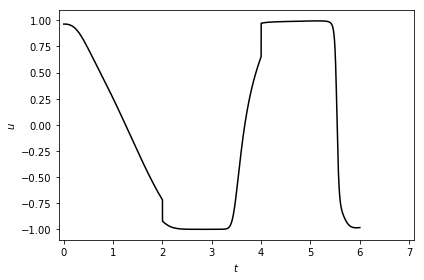

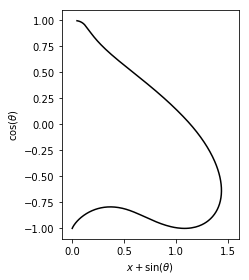

[0. 2. 4. 6.] [0.  0.5 1. ]


In [108]:
# times at which to switch
tfs = np.linspace(0, 6, 4)

# new alpha parameters
alphas = np.linspace(0, 1, len(tfs)-1)

# starting position
s0 = [0, 0, 3.141592653589793, 0]

# records
TL = np.empty(0)
SL = np.empty((0, seg.sdim))
UL = np.empty(0)

for i in range(len(tfs) - 1):
    
    # propagate
    tl, sl, ul = seg.propagate_controller(tfs[i+1] - tfs[i], s0, mlp.predict, alphas[i], atol=1e-13, rtol=1e-13)
    
    # new initial state
    s0 = sl[-1]
    
    # records
    TL = np.hstack((TL, tl + tfs[i]))
    SL = np.vstack((SL, sl))
    UL = np.hstack((UL, ul))
    
# plot controls
fig, ax = plt.subplots(1)
ax.plot(TL, UL, "k-")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$u$")
ax.set_xlim(-0.1, 7.1)
ax.set_ylim(-1.1, 1.1)
fig.tight_layout()
fig.savefig("pendulum_switching_control.pdf", bbox_inches="tight")
plt.show()

# plot trajectory
fig, ax = plt.subplots(1)
x = SL[:,0] + np.sin(SL[:,2])
y = np.cos(SL[:,2])
ax.plot(x, y, "k-")
ax.set_aspect("equal")
ax.set_xlabel(r"$x + \sin(\theta)$")
ax.set_ylabel(r"$\cos(\theta)$")
ax.set_xlim(-0.1, 1.6)
ax.set_ylim(-1.1, 1.1)
fig.tight_layout()
fig.savefig("pendulum_switching_traj.pdf", bbox_inches="tight")
plt.show()
print(tfs, alphas)

In [ ]:
# switching the objective times
tfs = [2, 4, 5]
alphas = [0, 0.5, 1]

# starting condition
s0 = res[0][0]

# propagate to some time
tl, sl, ul = seg.propagate_controller(ts[0], s0, mlp.predict, alphas[0], atol=1e-13, rtol=1e-13)

# initiate lists
TL = np.copy(tl)
SL = np.copy(sl)
UL = np.copy(ul)

# new starting state
s0 = sl[-1]
tl, sl, ul = seg.propagate_controller(tfs[1] - tl[-1], s0, mlp.predict, alphas[1], atol=1e-13, rtol=1e-13)
TL = np.hstack((TL, tl + tfs[1]))
SL = np.vstack((SL, sl))
UL = np.hstack((UL, ul))
SL

In [ ]:
s0

In [ ]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
na = 11
sa = np.linspace(0, 1, na)

for i, a in enumerate(sa):
    
    # get decision vector and homotopy parameter
    s0, z, alpha = res[np.argmin(abs(res[:105, 2] - a))]
    tf = z[0]
    
    # compute trajectory with policy 
    tl, sl, ul = seg.propagate_controller(tf, s0, mlp.predict, alpha, atol=1e-13, rtol=1e-13)
    
    # compute pendulum endpoints
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    
    # plot traj and controls
    ax.plot(x, y, "k-", alpha=0.4)
    ax1.plot(tl, ul, "k-", alpha=0.4)
    
ax.set_aspect('equal')
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$u$')
plt.show()
fig.savefig("pann_control.pdf", bbox_inches='tight')
fig1.savefig("pann_traj.pdf", bbox_inches='tight')

## Neural network accuracy

In [ ]:
n = 2

fig, ax = plt.subplots(n, sharex=True)
s = np.array([0, 0, np.pi, 0])
il = np.linspace(0, len(sols)-1, n, dtype=int)
for i, j in zip(il, range(n)):
    
    # simulate
    z = sols[i][0]
    alpha = sols[i][1]
    tl, sl, ul = seg.propagate(z[0], s, z[1:], alpha, u=True)
    tst = torch.tensor(np.hstack((sl[:, :seg.sdim], np.full((len(sl), 1), alpha))))
    tst = mlp(tst).detach().numpy().flatten()
    ax[j].plot(tl, ul, "k--")
    ax[j].plot(tl, tst, "k-", alpha=0.5)
    ax[j].set_title(r'$\alpha = {:.0f}$'.format(alpha))
    ax[j].set_ylabel(r'$u$')
    
ax[-1].set_xlabel(r'$\tau$')
ax[-1].legend(['Ground truth', 'Prediction'])
    
plt.tight_layout()
plt.show()
fig.savefig('punn.pdf', bbox_inches='tight')
fig1.savefig('punn_trajs.pdf', bbox_inches='tight')

In [ ]:
%matplotlib
# solutions
sols = np.load("ph.npy")

# number of homotopy parameters to sample
na = 2

# sample homotopy parameters
sa = np.linspace(0, 1, na)

# plot everything
fig, ax = plt.subplots(1)
for a in sa:
    
    # get homotopy solution instance
    z, alpha = sols[np.argmin(abs(sols[:,1] - a))]
    T = z[0]
    l0 = z[1:]
    
    # propagate trajectory with Pontryagin
    tl, sl, ul = seg.propagate(T, s0, l0, alpha, u=True)
    ax.plot(tl, ul, "k--")
    
    # predict controls with neural network
    tst = torch.tensor(np.hstack((sl[:, :seg.sdim], np.full((len(sl), 1), alpha))))
    tst = mlp(tst).detach().numpy().flatten()
    ax.plot(tl, tst, "k-", alpha=0.5)
    
    # propagate trajectory with neural network
    #tl, sl, ul = seg.propagate_controller(T, s0, mlp.predict, alpha, atol=1e-13, rtol=1e-13)
    #ax.plot(tl, ul, "k-", alpha=0.5)
    
plt.show()

## Policy trajectory optimality
Algorithm 1 Policy trajectory optimality
1: Given initial state xo and final time tf of trajectory from test set
2: Compute trajectory arising from policy with initial state xo and integration time tf
3: Extract final state xf from policy trajectory
4: Solve for optimal trajectory with initial state xo and final state xf
5: Evaluate objective function on policy trajectory and optimal trajectory: j
π
, j
∗
6: Compute relative error: (j
π − j
∗
)/j∗

In [ ]:
# given an initial state x0
# got it!

fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
seg.sf = np.zeros(seg.sdim)

# and final time tf
i = 0
z = sols[i][0]
tf = z[0]
alpha = sols[i][1]
beta = 1

# compute trajectory with policy with x0 and tf
tl, sl, ul = seg.propagate_controller(tf, s0, mlp.predict, alpha, atol=1e-12, rtol=1e-12)
x = sl[:,0] + np.sin(sl[:,2])
y = np.cos(sl[:,2])
ax.plot(x, y, "k-")
ax1.plot(tl, ul, "k-")
jp = seg.lagrangian(ul, alpha, beta)
jp = simps(jp, tl)

# extract final state from policy trajectory
# solve the trajectory from initial state to policy trajectory final state
seg.sf = sl[-1, :seg.sdim]
z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb=100, z=z)
tl, sl, ul = seg.propagate(z[0], s0, z[1:], alpha, atol=1e-12, rtol=1e-12, u=True)
x = sl[:,0] + np.sin(sl[:,2])
y = np.cos(sl[:,2])
ax.plot(x, y, "k--")
ax1.plot(tl, ul, "k--")
ax.set_aspect('equal')
jo = seg.lagrangian(ul, alpha, beta)
jo = simps(jo, tl)
plt.show()
alpha

In [ ]:
# number of homotopy parameters to sample
na = 11
beta = 0

# sample homotopy parameters
sa = np.linspace(0, 1, na)

# results
opt_array = np.zeros((na, len(pnets)))

# for each pendulum net
for i, net in enumerate(pnets):
    net.cpu()
    
    # for each homotopy parameter
    for j, a in enumerate(sa):

        # get decision vector and homotopy parameter
        seg.sf = np.zeros(seg.sdim)
        z, alpha = sols[np.argmin(abs(sols[:,1] - a))]
        tf = z[0]

        # compute trajectory with policy with x0 and tf
        tl, sl, ul = seg.propagate_controller(tf, s0, net.predict, alpha, atol=1e-12, rtol=1e-12)

        # compute cost of policy trajectory
        jp = seg.lagrangian(ul, alpha, beta)
        jp = simps(jp, tl)

        # compute optimal trajectory to xf from policy trajectory
        seg.sf = sl[-1, :seg.sdim]
        z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb=100, z=z)
        tl, sl, ul = seg.propagate(z[0], s0, z[1:], alpha, atol=1e-12, rtol=1e-12, u=True)

        # compute cost of optimal trajectory
        jo = seg.lagrangian(ul, alpha, beta)
        jo = simps(jo, tl)
        
        # compute relative optimality
        e = abs(jp - jo)/jo
        
        # message
        print("The optimality of net {} at alpha = {:.4f} is {:6f}".format(net.shape, alpha, e*100))
        
        # record
        opt_array[j, i] = e 

In [ ]:
import pandas as pd

In [ ]:
cols = [r'${} \times {}$'.format(net.shape[1], net.nl) for net in pnets]
rows = ['{:.1f}'.format(a) for a in sa]
df = pd.DataFrame(opt_array*100, columns=cols, index=rows)
print(df.to_latex(header="Architecture"))

In [ ]:
df.mean(axis=0)